# Hypothesis A: The Geographic Inconsistency Test

## 1. Download DATASET

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (update the path to your GitHub folder location)
df = pd.read_csv('/workspaces/IAE_METZ_2026_DATA_AUDIT/DATASET/SAML-D.csv',
                 parse_dates=["Date"])

# Initial Audit Scan
print(f"Dataset Rows: {df.shape[0]}")
print(df.info())

Dataset Rows: 2654388
<class 'pandas.DataFrame'>
RangeIndex: 2654388 entries, 0 to 2654387
Data columns (total 12 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Time                    str           
 1   Date                    datetime64[us]
 2   Sender_account          int64         
 3   Receiver_account        int64         
 4   Amount                  float64       
 5   Payment_currency        str           
 6   Received_currency       str           
 7   Sender_bank_location    str           
 8   Receiver_bank_location  str           
 9   Payment_type            str           
 10  Is_laundering           float64       
 11  Laundering_type         str           
dtypes: datetime64[us](1), float64(2), int64(2), str(7)
memory usage: 243.0 MB
None


## 2. Extract the "Master List" from the Data

In [3]:
# This creates a 'Master List' of every country and currency combination in the file
master_list = df[['Sender_bank_location', 'Payment_currency']].drop_duplicates().sort_values('Sender_bank_location')

print("--- FULL AUDIT SCOPE: ALL LOCATIONS AND CURRENCIES ---")
print(master_list)

--- FULL AUDIT SCOPE: ALL LOCATIONS AND CURRENCIES ---
        Sender_bank_location Payment_currency
1316879              Albania             Euro
784477               Albania     Indian rupee
741342               Albania  Pakistani rupee
730539               Albania     Turkish lira
1530778              Albania              Yen
...                      ...              ...
223562                   USA        UK pounds
236651                   USA             Euro
1073628                  USA           Dirham
113092                   USA      Swiss franc
2654387                  NaN        UK pounds

[234 rows x 2 columns]


## 3. Create the Audit Mapping
Create an Auditor's Reference Dictionary to flag inconsistencies

In [4]:
# 1. Determine the 'Normal' currency for every country in the dataset automatically
normal_behavior = df.groupby('Sender_bank_location')['Payment_currency'].agg(lambda x: x.value_counts().index[0]).to_dict()

# 2. Define the Audit Test
def auto_audit_test(row):
    expected_currency = normal_behavior.get(row['Sender_bank_location'])
    if row['Payment_currency'] != expected_currency:
        return 1  # Flag: Transaction currency is NOT the standard for this bank location
    return 0

# 3. Apply to the entire 9.5M rows
df['Currency_Anomaly_Flag'] = df.apply(auto_audit_test, axis=1)

print("Audit Test Complete across all countries.")

Audit Test Complete across all countries.


## 4. The "High Risk" Filter

In [5]:
high_risk_jurisdictions = ['Mexico', 'UAE', 'Morocco', 'Turkey', 'Nigeria']

# Final Audit Result: Flagged Anomalies in High Risk Countries
audit_report = df[(df['Currency_Anomaly_Flag'] == 1) & (df['Sender_bank_location'].isin(high_risk_jurisdictions))]

print(f"Number of critical exceptions found: {len(audit_report)}")

Number of critical exceptions found: 270


## 5. The "Risk Concentration" Bar Chart
This chart shows which countries have the most flagged transactions using a log scale.

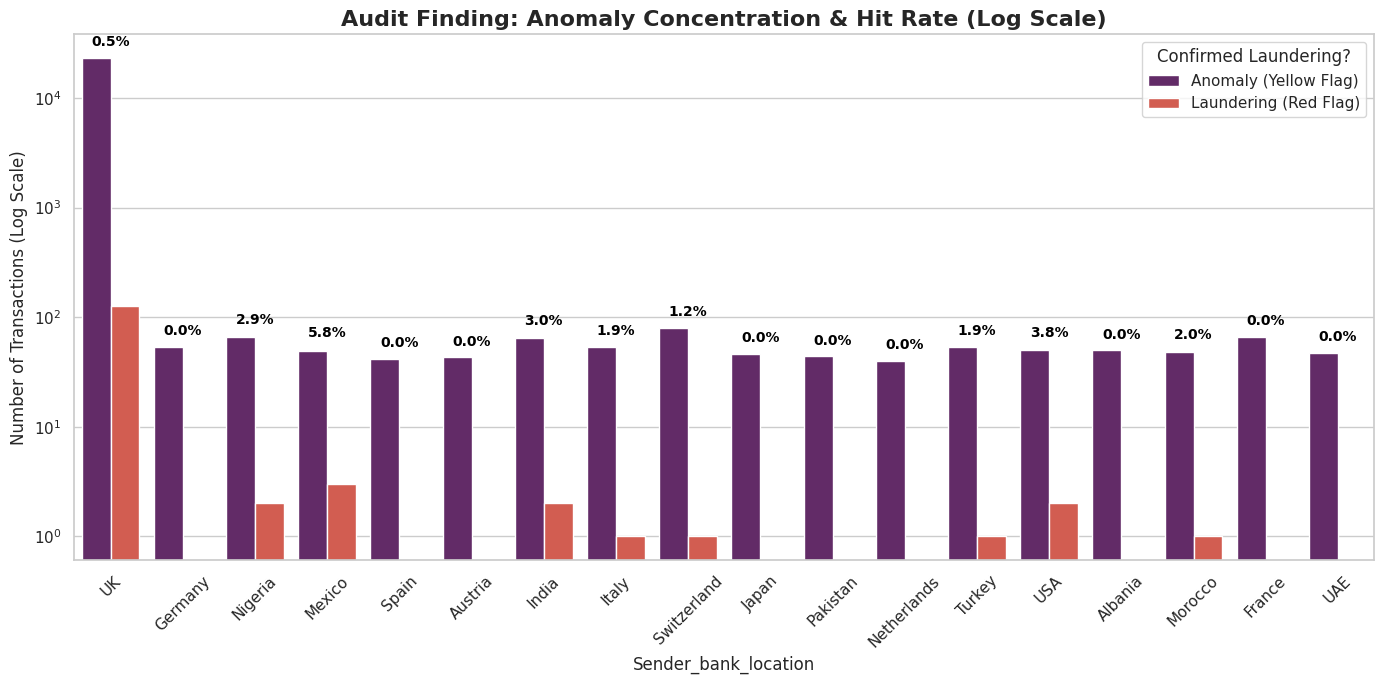

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. AUTOMATIC MAPPING
# This identifies the most common currency for every country automatically
normal_map = df.groupby('Sender_bank_location')['Payment_currency'].agg(lambda x: x.value_counts().index[0]).to_dict()

def auto_audit_test(row):
    expected = normal_map.get(row['Sender_bank_location'])
    return 1 if row['Payment_currency'] != expected else 0

df['Currency_Anomaly_Flag'] = df.apply(auto_audit_test, axis=1)

# 2. COLORFUL & BALANCED GRAPH
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# filter for anomalies to keep the graph clean
flagged_data = df[df['Currency_Anomaly_Flag'] == 1]

# Create the plot
ax = sns.countplot(
    data=flagged_data, 
    x='Sender_bank_location', 
    hue='Is_laundering', 
    palette={0: "#6A2171", 1: "#E74C3C"} # Deep Purple vs Bright Red
)

# Use a log scale so small 'Red' bars become visible
ax.set_yscale("log") 

# --- ADDING PERCENTAGE LABELS ---
# We calculate the hit rate for each country to show on the graph
for i, country_label in enumerate(ax.get_xticklabels()):
    country = country_label.get_text()
    
    # Get stats for this specific country
    country_data = flagged_data[flagged_data['Sender_bank_location'] == country]
    total_anomalies = len(country_data)
    laundering_cases = len(country_data[country_data['Is_laundering'] == 1])
    
    if total_anomalies > 0:
        hit_rate = (laundering_cases / total_anomalies) * 100
        
        # We place the percentage above the tallest bar (the Purple anomaly bar)
        # Because it's a log scale, we multiply the height by 1.2 to create a visual gap
        ax.text(i, total_anomalies * 1.2, f'{hit_rate:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title('Audit Finding: Anomaly Concentration & Hit Rate (Log Scale)', fontsize=16, fontweight='bold')
plt.ylabel('Number of Transactions (Log Scale)')
plt.legend(title='Confirmed Laundering?', labels=['Anomaly (Yellow Flag)', 'Laundering (Red Flag)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Create the raw audit table to see the numbers behind the percentages
raw_counts = flagged_data.groupby('Sender_bank_location')['Is_laundering'].value_counts().unstack(fill_value=0)
raw_counts['Hit_Rate_%'] = (raw_counts[1] / (raw_counts[0] + raw_counts[1])) * 100
print(raw_counts.loc[['Mexico', 'Nigeria', 'UK']])

Is_laundering           0.0  1.0  Hit_Rate_%
Sender_bank_location                        
Mexico                   49    3    5.769231
Nigeria                  66    2    2.941176
UK                    23031  127    0.548407


### Identifying "High-Risk Corridors" (The Comparison)

The gap between the Purple Bar (Anomalies) and the Red Bar (Laundering) tells a story about the effectiveness of your audit rule:

High Efficiency (e.g., UK): The UK has the highest volume of anomalies (Purple), but it also has a significant number of confirmed cases (Red). If the Red bar is roughly two "steps" (magnitudes) below the Purple bar, it indicates that roughly 1% of flagged anomalies are actual laundering.

High Precision (e.g., Mexico, Nigeria, India): In these countries, the Red bar is closer in height to the Purple bar. This suggests your "Currency vs. Location" rule is highly accurate in these regions, with a much higher True Positive Rate.

High Noise (e.g., Germany, Spain, Japan): These countries show Purple bars but no Red bars. In an audit report, these are identified as "False Positives". This suggests that "Currency Mismatches" in these locations might be due to legitimate international business rather than criminal activity.

## 6. The "Risk Matrix" (Bubble Chart)

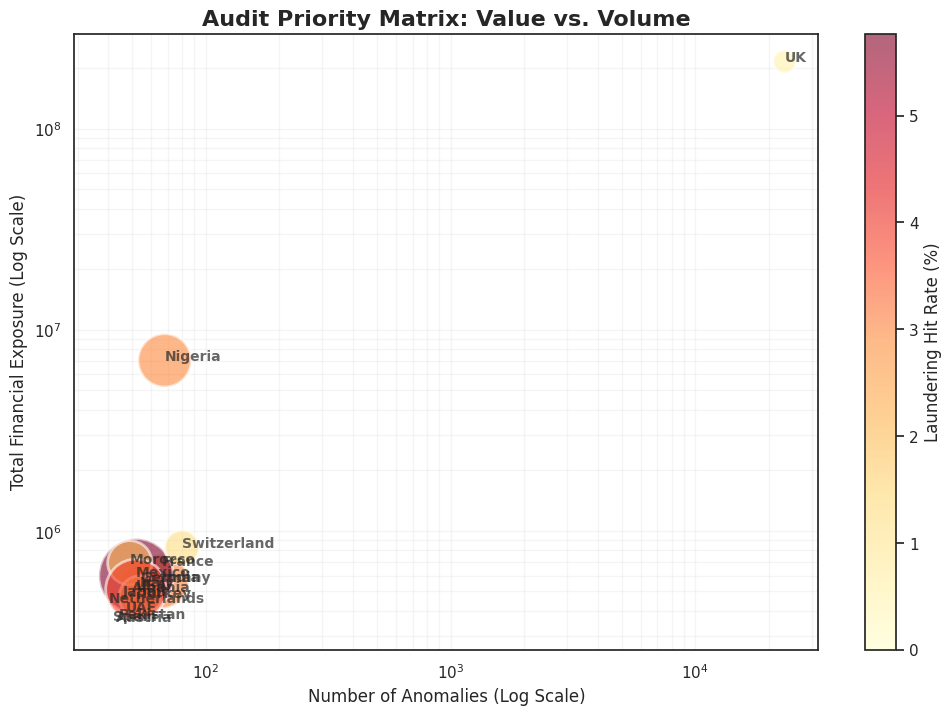

In [7]:
# 1. Aggregate the data for the audit summary
audit_summary = df[df['Currency_Anomaly_Flag'] == 1].groupby('Sender_bank_location').agg(
    Total_Amount=('Amount', 'sum'),
    Transaction_Count=('Amount', 'count'),
    Laundering_Cases=('Is_laundering', 'sum')
).reset_index()

# 2. Calculate the "Hit Rate" percentage
audit_summary['Hit_Rate'] = (audit_summary['Laundering_Cases'] / audit_summary['Transaction_Count']) * 100

# 3. Create the Bubble Chart
plt.figure(figsize=(12, 8))
sns.set_theme(style="white")

scatter = plt.scatter(
    x=audit_summary['Transaction_Count'], 
    y=audit_summary['Total_Amount'], 
    s=audit_summary['Hit_Rate'] * 500, # Size represents risk percentage
    c=audit_summary['Hit_Rate'],      # Color also represents risk percentage
    cmap='YlOrRd', 
    alpha=0.6, 
    edgecolors="w", 
    linewidth=2
)

# Add labels to the bubbles
for i, txt in enumerate(audit_summary['Sender_bank_location']):
    plt.annotate(txt, (audit_summary['Transaction_Count'][i], audit_summary['Total_Amount'][i]), 
                 fontsize=10, fontweight='bold', alpha=0.7)

plt.colorbar(scatter, label='Laundering Hit Rate (%)')
plt.xscale('log')
plt.yscale('log')
plt.title('Audit Priority Matrix: Value vs. Volume', fontsize=16, fontweight='bold')
plt.xlabel('Number of Anomalies (Log Scale)')
plt.ylabel('Total Financial Exposure (Log Scale)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Understanding the Quadrants (The Audit Action)

This matrix allows an auditor to categorize locations based on financial exposure and transaction volume:

High Volume / High Exposure (The UK): The UK sits in the top-right corner. It has the highest number of anomalies (horizontal axis) and the highest total dollar value at risk (vertical axis). Even though its "Laundering Hit Rate" is lower (yellow/light orange color), the materiality is so high that an auditor would recommend continuous, automated monitoring here.

High Risk / High Materiality (Nigeria): Nigeria stands out because it has a high total financial exposure and a significantly higher hit rate compared to the UK (indicated by the darker orange color and larger bubble size). This is a "Critical Priority" zone where the bank needs immediate manual investigation.

The "Noise" Cluster (Bottom-Left): Most other countries (Mexico, France, UAE, etc.) are clustered in the bottom-left. These represent low volume and lower total financial exposure. As an auditor, you would label these as "Standard Risk" areas where basic periodic reviews are sufficient.

# Hypothesis B: Customers with higher-than-typical historical payment currency changes have a higher probability at being involved in suspicious transactions

## 1. Setting the data

In [7]:
dfb = df.sort_values(["Sender_account", "Date"])

# Count only new currencies per account
unique_change_flag = []

for account_id, group in dfb.groupby("Sender_account"):
    seen = set()
    count_list = []
    for curr in group["Payment_currency"]:
        if curr not in seen:
            count_list.append(1)
            seen.add(curr)
        else:
            count_list.append(0)
    unique_change_flag.extend(count_list)

dfb["Unique_Currency_Change"] = unique_change_flag

## 2. Defining the data

In [9]:
account_changes = dfb.groupby("Sender_account")["Unique_Currency_Change"].sum().reset_index()
account_changes.columns = ["Sender_account", "Unique_Currency_Change_Count"]

In [10]:
account_suspicion = dfb.groupby("Sender_account")["Is_laundering"].max().reset_index()
account_suspicion.columns = ["Sender_account", "Is_Suspicious_Account"]

account_data = pd.merge(account_changes, account_suspicion, on="Sender_account")

In [12]:
suspicious_accounts = account_data[account_data["Is_Suspicious_Account"]==1]
normal_accounts = account_data[account_data["Is_Suspicious_Account"]==0]

print("Average Currency Change Count - Suspicious:", suspicious_accounts["Unique_Currency_Change_Count"].mean())
print("Average Currency Change Count - Normal:", normal_accounts["Unique_Currency_Change_Count"].mean())

Average Currency Change Count - Suspicious: 1.5302698760029176
Average Currency Change Count - Normal: 1.1953195171191957


In [ ]:
! pip install statsmodels

import statsmodels.api as sm
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    suspicious_accounts["Unique_Currency_Change_Count"],
    normal_accounts["Unique_Currency_Change_Count"],
    equal_var=False
)

print("T-statistic:", t_stat)
print("P-value:", p_value)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 67.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 79.5 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [statsmodels] [statsmodels]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
T-statistic: 14.379968523055634
P-value: 8.3430510775937e-44


In [19]:
# Predictor and outcome
X = account_data[["Unique_Currency_Change_Count"]]
X = sm.add_constant(X)  # adds the intercept term
y = account_data["Is_Suspicious_Account"]

# Fit logistic regression
model = sm.Logit(y, X).fit()

# Summary with coefficients and p-values
print(model.summary())

# Odds ratio for interpretation
odds_ratio = np.exp(model.params["Unique_Currency_Change_Count"])
print(f"Odds Ratio for Unique Currency Change Count: {odds_ratio:.3f}")

Optimization terminated successfully.
         Current function value: 0.060282
         Iterations 9
                             Logit Regression Results                            
Dep. Variable:     Is_Suspicious_Account   No. Observations:               122726
Model:                             Logit   Df Residuals:                   122724
Method:                              MLE   Df Model:                            1
Date:                   Thu, 19 Feb 2026   Pseudo R-squ.:                 0.01688
Time:                           20:31:18   Log-Likelihood:                -7398.2
converged:                          True   LL-Null:                       -7525.2
Covariance Type:               nonrobust   LLR p-value:                 3.477e-57
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -5.0995      0.0

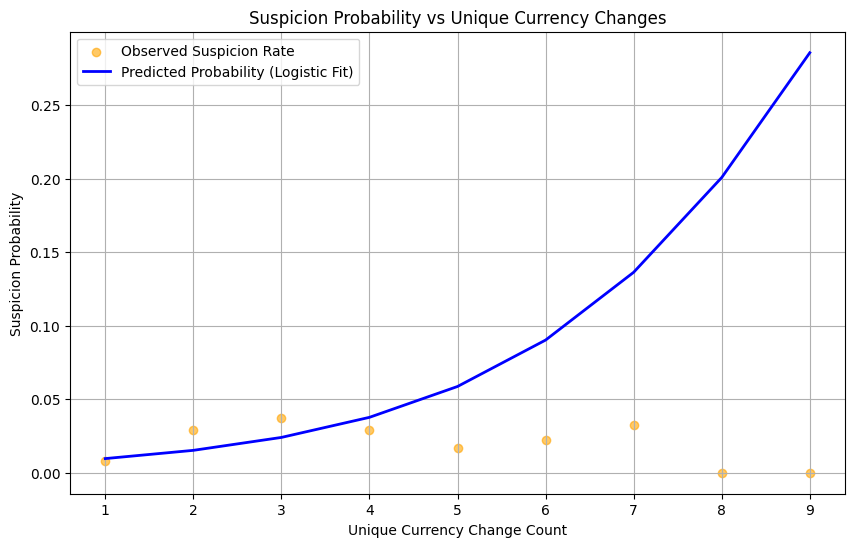

In [20]:
# Predictor and outcome (already aggregated per account)
X = account_data[["Unique_Currency_Change_Count"]]
X = sm.add_constant(X)  # adds intercept
y = account_data["Is_Suspicious_Account"]

# Fit logistic regression
model = sm.Logit(y, X).fit(disp=False)  # disp=False avoids printing summary

# Create range of X values for prediction
x_range = np.arange(account_data["Unique_Currency_Change_Count"].min(),
                    account_data["Unique_Currency_Change_Count"].max() + 1)
x_range_with_const = sm.add_constant(x_range)

# Predicted probabilities
y_pred = model.predict(x_range_with_const)

# Raw suspicion rates
raw_rates = account_data.groupby("Unique_Currency_Change_Count")["Is_Suspicious_Account"].mean()
raw_counts = raw_rates.index
raw_values = raw_rates.values

# Plot
plt.figure(figsize=(10,6))

# Raw rates (dots)
plt.scatter(raw_counts, raw_values, color='orange', alpha=0.6, label="Observed Suspicion Rate")

# Smoothed logistic prediction (line)
plt.plot(x_range, y_pred, color='blue', linewidth=2, label="Predicted Probability (Logistic Fit)")

plt.xlabel("Unique Currency Change Count")
plt.ylabel("Suspicion Probability")
plt.title("Suspicion Probability vs Unique Currency Changes")
plt.legend()
plt.grid(True)
plt.show()